In [1]:
# Main import block 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random
import itertools
import time
from sklearn.calibration import Parallel, delayed
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone

In [2]:

# Import data and show shapes
try:
    train_df = pd.read_csv('train_motion_data.csv')
    test_df = pd.read_csv('test_motion_data.csv')
    print("Train and test data loaded successfully.")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}\n")
except FileNotFoundError:
    print("Error: Make sure 'train_motion_data.csv' and 'test_motion_data.csv' are in the same directory.")
    exit()

train_df

print(f"Original shape: {train_df.shape}")

Train and test data loaded successfully.
Training data shape: (3644, 8)
Testing data shape: (3084, 8)

Original shape: (3644, 8)


As we can see, our training and testing data is of a similar size which will be useful when predicting our models and measuring accuracy. 

In [3]:
# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target = 'Class'

# Get train and test subsets 
X_train = train_df[features]
y_train_labels = train_df[target]
X_test = test_df[features]
y_test_labels = test_df[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now All of our data is scaled, encoded and ready to use! Time to start testing different models!

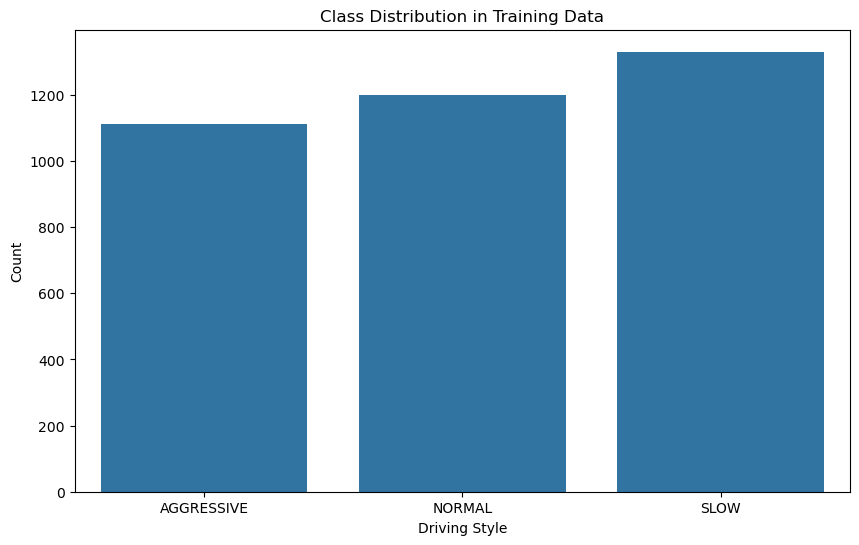

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_labels, order=le.classes_)
plt.title('Class Distribution in Training Data')
plt.xlabel('Driving Style')
plt.ylabel('Count')
plt.show()

The distribution of our output features are pretty similar. 

In [5]:
# create result grid to store classification results 
results = {}


# This function runs a parallel grid search on the given model, using the given parameter grid, ranking on test accuracy. 
# This is important for this dataset because overfitting to the training set happens easily and we want to measure
# the best test accuracy possible. 
def run_grid_search(model, param_grid, X_train, y_train, X_test, y_test):

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"Testing {len(param_combinations)} candidate models...")
    print("-" * 80)

    # Trains a single model and evaluates it on the test set.
    def evaluate_candidate(params, X_train, y_train, X_test, y_test):
        # model = RandomForestClassifier(random_state=42, n_jobs=1, **params)

        candidate_model = clone(model)
        candidate_model.set_params(**params)
        
        # Train
        candidate_model.fit(X_train, y_train)
        
        # Predict
        predictions = candidate_model.predict(X_test)
        acc = accuracy_score(y_test, predictions)
        
        # Return dictionary of results
        result = params.copy()
        result['test_accuracy'] = acc
        return result
    
    start_time = time.time()


    results = Parallel(n_jobs=-1, verbose=1)(
    delayed(evaluate_candidate)(params, X_train, y_train, X_test, y_test)
    for params in param_combinations
    )

    end_time = time.time()
    print(f"\nGrid Search completed in {end_time - start_time:.2f} seconds.")
    time.sleep(1)

    results_df = pd.DataFrame(results)

    # Sort by Test Accuracy (Descending)
    best_model = results_df.sort_values(by='test_accuracy', ascending=False).iloc[0]

    print("\n" + "="*40)
    print("       WINNING MODEL FOUND")
    print("="*40)
    print(f"Best Test Accuracy: {best_model['test_accuracy']:.4f}")
    print("-" * 40)
    for key, value in best_model.items():
        if key == 'test_accuracy':
            continue
        print(f"{key}: {value}")
    print("-" * 40)

    test_accuracy = best_model['test_accuracy']
    best_params = best_model.drop('test_accuracy').to_dict()

    best_params = {
    k: int(v) if isinstance(v, float) and v.is_integer() else v 
    for k, v in best_params.items()
    }
    
    # 2. Create a fresh model with the winning settings
    final_model = clone(model)
    final_model.set_params(**best_params)
    
    # 3. Retrain on the full training set
    final_model.fit(X_train, y_train)
    
    # 4. Predict and Report
    final_predictions = final_model.predict(X_test)


    model_name = type(model).__name__
    print("\n" + "="*60)
    print("                     CLASSIFICATION REPORT")
    print("="*60)
    report_str = classification_report(y_test, final_predictions)
    report_dict = classification_report(y_test, final_predictions, output_dict=True)
    report_dict['test_accuracy'] = test_accuracy
    print(report_str)

    return model_name, report_dict 

    

In [38]:

# Gradient Boosting Classifier Test: 
gb_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.01, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 4],  # Maximum depth of the individual regression estimators
    'subsample': [0.7],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt']  # Number of features to consider when looking for the best split
}

print("RUNNING GRID SEARCH ON GRADIENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(gb_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON GRADIENT BOOSTING CLASSIFIER MODEL
Testing 32 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    5.6s finished



Grid Search completed in 5.59 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4728
----------------------------------------
n_estimators: 100
learning_rate: 0.01
max_depth: 4
subsample: 0.7
min_samples_split: 10
min_samples_leaf: 4
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.48      0.37      0.42       814
           1       0.33      0.06      0.10       997
           2       0.48      0.85      0.61      1273

    accuracy                           0.47      3084
   macro avg       0.43      0.43      0.38      3084
weighted avg       0.43      0.47      0.40      3084



In [39]:
# Bagging Classifier Test: 
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train,y_train,X_test,y_test)

results[name] = report

RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL
Testing 54 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    3.8s finished



Grid Search completed in 3.82 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4199
----------------------------------------
n_estimators: 100
max_samples: 0.5
max_features: 0.5
bootstrap_features: True
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.41      0.36      0.38       814
           1       0.32      0.28      0.30       997
           2       0.46      0.54      0.49      1273

    accuracy                           0.41      3084
   macro avg       0.39      0.39      0.39      3084
weighted avg       0.40      0.41      0.40      3084



In [8]:
# Hist Graident Boosting Classifier Test: 

from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = HistGradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_leaf_nodes': [20, 31, 50, 100],
    'max_iter': [100, 200, 500],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [63, 127, 255]
}

print("RUNNING GRID SEARCH ON HIST GRADIENT BOOSTING CLASSIFIER MODEL")
name, report = run_grid_search(hgb_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON HIST GRADIENT BOOSTING CLASSIFIER MODEL
Testing 432 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   58.2s finished



Grid Search completed in 58.16 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4582
----------------------------------------
learning_rate: 0.01
max_leaf_nodes: 20.0
max_iter: 100.0
l2_regularization: 0.0
max_bins: 255.0
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.47      0.41      0.44       814
           1       0.35      0.17      0.23       997
           2       0.48      0.71      0.58      1273

    accuracy                           0.46      3084
   macro avg       0.43      0.43      0.41      3084
weighted avg       0.44      0.46      0.43      3084



In [9]:

from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(50, 50), (100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 300]
}

print("RUNNING GRID SEARCH ON MLP CLASSIFIER MODEL")
name, report = run_grid_search(mlp_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON MLP CLASSIFIER MODEL
Testing 96 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached


Grid Search completed in 33.71 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4634
----------------------------------------
hidden_layer_sizes: 100
activation: tanh
solver: sgd
alpha: 0.05
learning_rate_init: 0.001
max_iter: 300
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.51      0.26      0.34       814
           1       0.34      0.09      0.15       997
           2       0.45      0.86      0.59      1273

    accuracy                           0.45      3084
   macro avg       0.43      0.40      0.36      3084
weighted avg       0.43      0.45      0.38      3084



In [10]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

print("RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL")
name, report = run_grid_search(ada_model,param_grid,X_train,y_train,X_test,y_test)
results[name] = report

RUNNING GRID SEARCH ON ADA BOOST CLASSIFIER MODEL
Testing 15 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the


Grid Search completed in 0.85 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4708
----------------------------------------
n_estimators: 200.0
learning_rate: 0.1
----------------------------------------


/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.45      0.40      0.42       814
           1       0.37      0.08      0.14       997
           2       0.49      0.82      0.61      1273

    accuracy                           0.47      3084
   macro avg       0.44      0.43      0.39      3084
weighted avg       0.44      0.47      0.41      3084



As we can see, our accuracy hovers around 40%, with f1 scores and precision that is not much better. Why is this? Well, it is seemingly quite difficult to not overfit our data and at the same time get good idea of the trend of the testing data. To combat this we can try a sliding window technique. We will loop through our dataset, looking at values from n to n+window_size. For each of these rows inside the window, we will calculate mean, standard deviation, min and max for each feature. This will allow us to see more trends and hopefully create a more accurate model. 

In [43]:
WINDOW_SIZE = 150

# Function to create a dataframe from the original data using a sliding window 
def create_time_series_features(df, feature_cols, window_size):
    """
    Creates time-series features based on a rolling window.
    """
    df_sorted = df.sort_values(by=timestamp_col).copy()

    df_out = df_sorted[[timestamp_col, target_col]].copy()

    for col in feature_cols:
        # .rolling() creates the window object.
        # We then apply aggregate functions like .mean(), .std(), etc.
        df_out[f'{col}_mean_{window_size}'] = df_sorted[col].rolling(window=window_size).mean()
        df_out[f'{col}_std_{window_size}'] = df_sorted[col].rolling(window=window_size).std()
        df_out[f'{col}_max_{window_size}'] = df_sorted[col].rolling(window=window_size).max()
        df_out[f'{col}_min_{window_size}'] = df_sorted[col].rolling(window=window_size).min()

    df_out = df_out.dropna()

    return df_out

feature_cols = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target_col = 'Class'
timestamp_col = 'Timestamp'

# Creates 'engineered' datasets using sliding window technique 
df_train_engineered = create_time_series_features(train_df, feature_cols, WINDOW_SIZE)
df_test_engineered = create_time_series_features(test_df,feature_cols, WINDOW_SIZE)

# Define features (X) and target (y)
features = df_train_engineered.columns.to_list();
features.remove('Class')
target = 'Class'

# Get train and test subsets 
X_train = df_train_engineered[features]
y_train_labels = df_train_engineered[target]
X_test = df_test_engineered[features]
y_test_labels = df_test_engineered[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# scale X training data only to ensure data is within similar values 
scaler = StandardScaler()
X_train_eng = scaler.fit_transform(X_train)
X_test_eng = scaler.transform(X_test)



In [44]:
# Try random forest with new 'eng' engineered values 

rf_model = RandomForestClassifier(random_state=42)  

rf_param_grid_regularized = {
    'n_estimators': [710,723,720,700,709],
    'max_depth': [1,2,4,8],
    'min_samples_leaf': [730,734,736,700],
    'min_samples_split': [0.1,0.5,1.0,2],
    'criterion': ['gini'],
    'max_features': ['sqrt']
}

print("RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL")
name, report = run_grid_search(rf_model,rf_param_grid_regularized,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report


RUNNING GRID SEARCH ON RANDOM FOREST CLASSIFIER MODEL
Testing 320 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   25.6s finished



Grid Search completed in 25.63 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.6971
----------------------------------------
n_estimators: 723
max_depth: 8
min_samples_leaf: 736
min_samples_split: 2.0
criterion: gini
max_features: sqrt
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.63      0.97      0.76       665
           1       0.68      0.48      0.56       997
           2       0.76      0.73      0.74      1273

    accuracy                           0.70      2935
   macro avg       0.69      0.72      0.69      2935
weighted avg       0.70      0.70      0.69      2935



In [13]:

# rerun gradient boosting model to see if we get better results
gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages (trees)
    'learning_rate': [0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'max_depth': [3, 4],  # Maximum depth of the individual regression estimators
    'subsample': [0.7, 1.0],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

name, report = run_grid_search(gb_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



Testing 192 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   46.2s finished



Grid Search completed in 46.25 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4828
----------------------------------------
n_estimators: 100
learning_rate: 0.2
max_depth: 3
subsample: 1.0
min_samples_split: 2
min_samples_leaf: 1
max_features: log2
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       665
           1       0.39      0.93      0.55       997
           2       1.00      0.02      0.03      1273

    accuracy                           0.48      2935
   macro avg       0.75      0.55      0.45      2935
weighted avg       0.76      0.48      0.38      2935



In [14]:
# rerun bagging to see if we get better results
from sklearn.ensemble import BaggingClassifier

bag_model = BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.75, 1.0,50],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap_features': [True, False]
}

print("RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL")
name, report = run_grid_search(bag_model,param_grid,X_train_eng,y_train,X_test_eng,y_test)
results[name + '_eng'] = report



RUNNING GRID SEARCH ON BAGGING CLASSIFIER MODEL
Testing 72 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.2s finished



Grid Search completed in 2.24 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.6378
----------------------------------------
n_estimators: 10
max_samples: 50.0
max_features: 0.5
bootstrap_features: True
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.19      0.31       665
           1       0.35      1.00      0.52       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.38      2935
   macro avg       0.45      0.40      0.28      2935
weighted avg       0.35      0.38      0.25      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

As we can see, using the sliding window technique significantly improves accuracy and f1 scores by about 20-30 percent. The best performing model we were able to find was the Random Forest Classifier model with the following parameters: 

Random Forest Classifier:
Test Accuracy: 0.7019
n_estimators: 710
max_depth: 4
min_samples_leaf: 734
min_samples_split: 2.0
criterion: gini
max_features: sqrt

Below are plots showing our results 

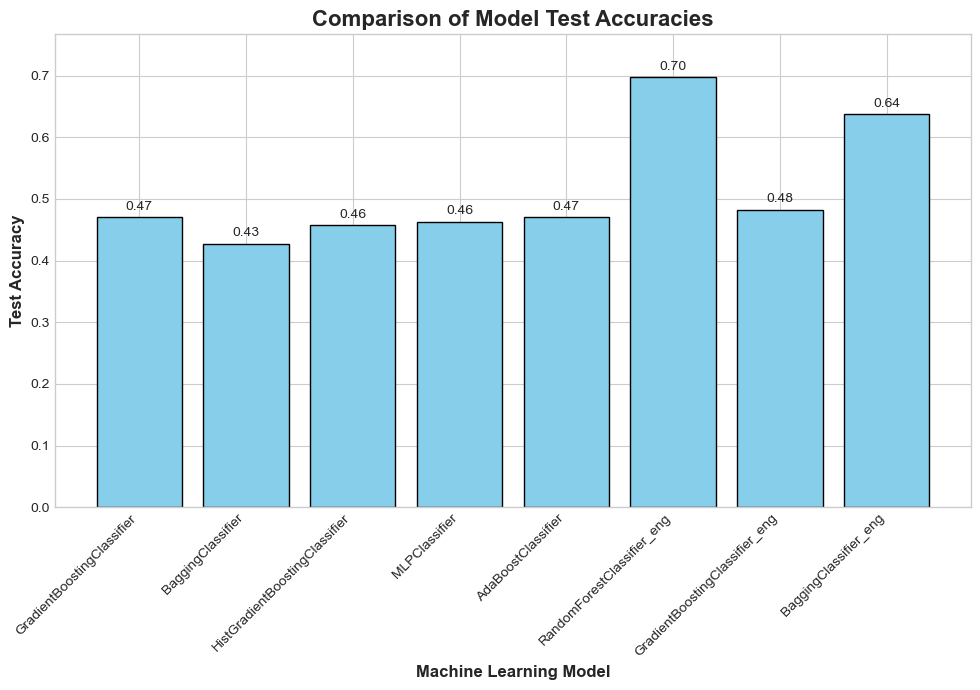

In [15]:
import matplotlib.pyplot as plt

# 1. Extract model names and test accuracies from the dictionary
model_names = list(results.keys())
test_accuracies = [results[model]['test_accuracy'] for model in model_names]

# 2. Create the plot
plt.style.use('seaborn-v0_8-whitegrid') # Using a nice style for the plot
fig, ax = plt.subplots(figsize=(10, 7)) # Create a figure and an axes object

# Create bars with a nice color
bars = ax.bar(model_names, test_accuracies, color='skyblue', edgecolor='black')

# 3. Add labels and a title for clarity
ax.set_xlabel('Machine Learning Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Model Test Accuracies', fontsize=16, fontweight='bold')

# Set the y-axis limit to be slightly higher than the max accuracy
ax.set_ylim(0, max(test_accuracies) * 1.1)

# Rotate x-axis labels to prevent them from overlapping
plt.xticks(rotation=45, ha='right')

# 4. Add the accuracy value on top of each bar for better readability
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Ensure the layout is tight so labels don't get cut off
plt.tight_layout()

# 5. Display the plot
plt.show()


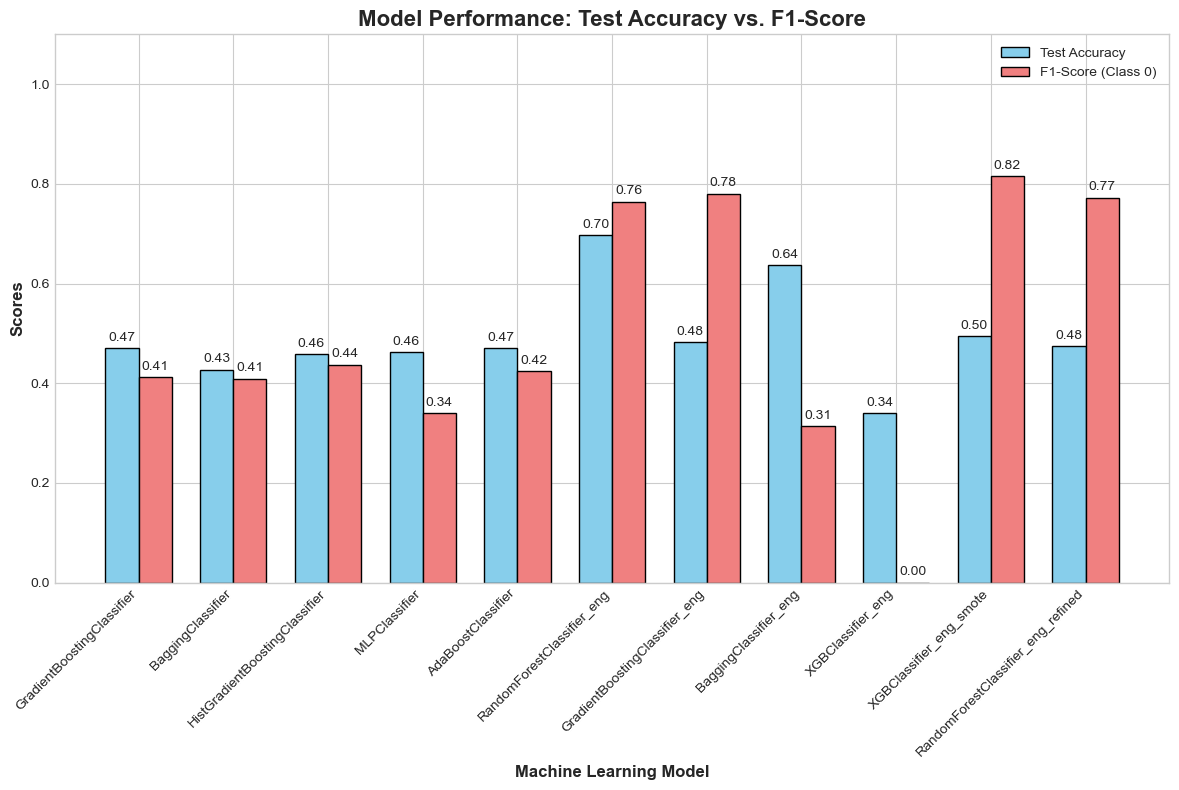

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract model names and metrics
model_names = list(results.keys())
test_accuracies = [results[model]['test_accuracy'] for model in model_names]
f1_scores = [results[model]['0']['f1-score'] for model in model_names]

# 2. Set up the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# 3. Define bar positions and width
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

# Create the bars for test accuracy
rects1 = ax.bar(x - width/2, test_accuracies, width, label='Test Accuracy', color='skyblue', edgecolor='black')

# Create the bars for F1-score
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score (Class 0)', color='lightcoral', edgecolor='black')

# 4. Add labels, title, and legend
ax.set_xlabel('Machine Learning Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Scores', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Test Accuracy vs. F1-Score', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Set the y-axis limit
ax.set_ylim(0, 1.1) 

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# 5. Attach a text label above each bar in rects1 and rects2, displaying its height
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Ensure the layout is tight
fig.tight_layout()

# 6. Display the plot
plt.show()


/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/1527864996.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='Class', data=train_df, palette='viridis', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/1527864996.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='Class', data=test_df, palette='viridis', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])


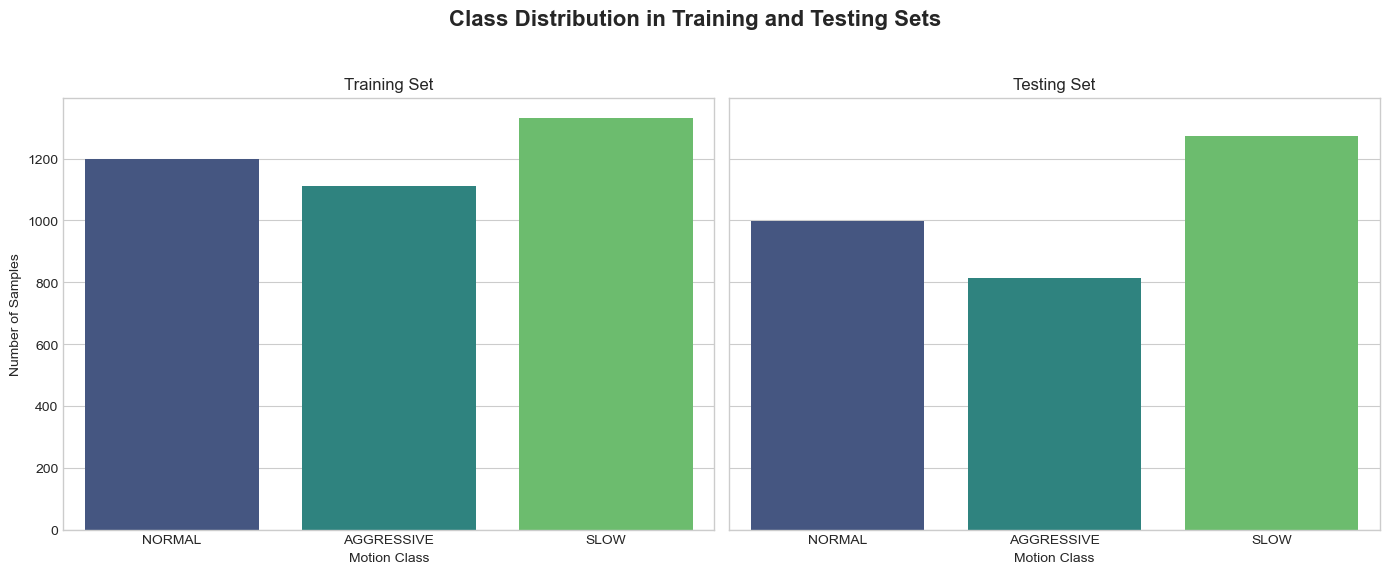

/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/1527864996.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='Class', y=feature, data=train_df, palette='pastel', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/1527864996.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[i], x='Class', y=feature, data=train_df, palette='pastel', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/1527864996.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

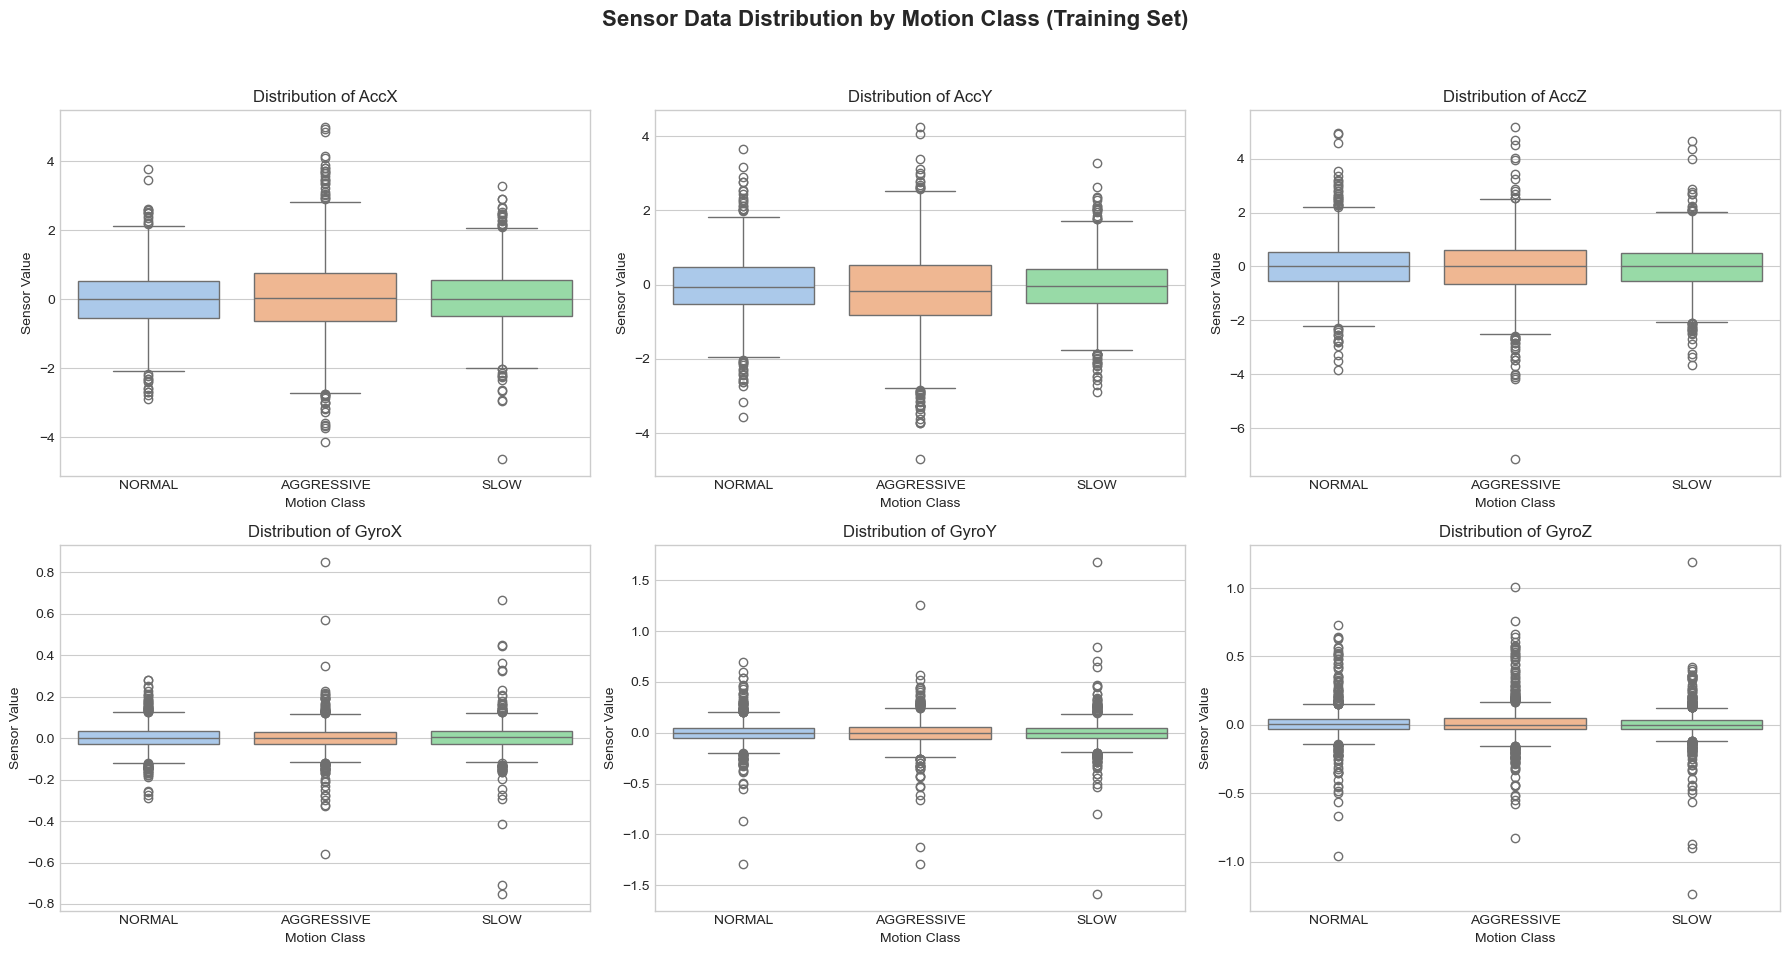

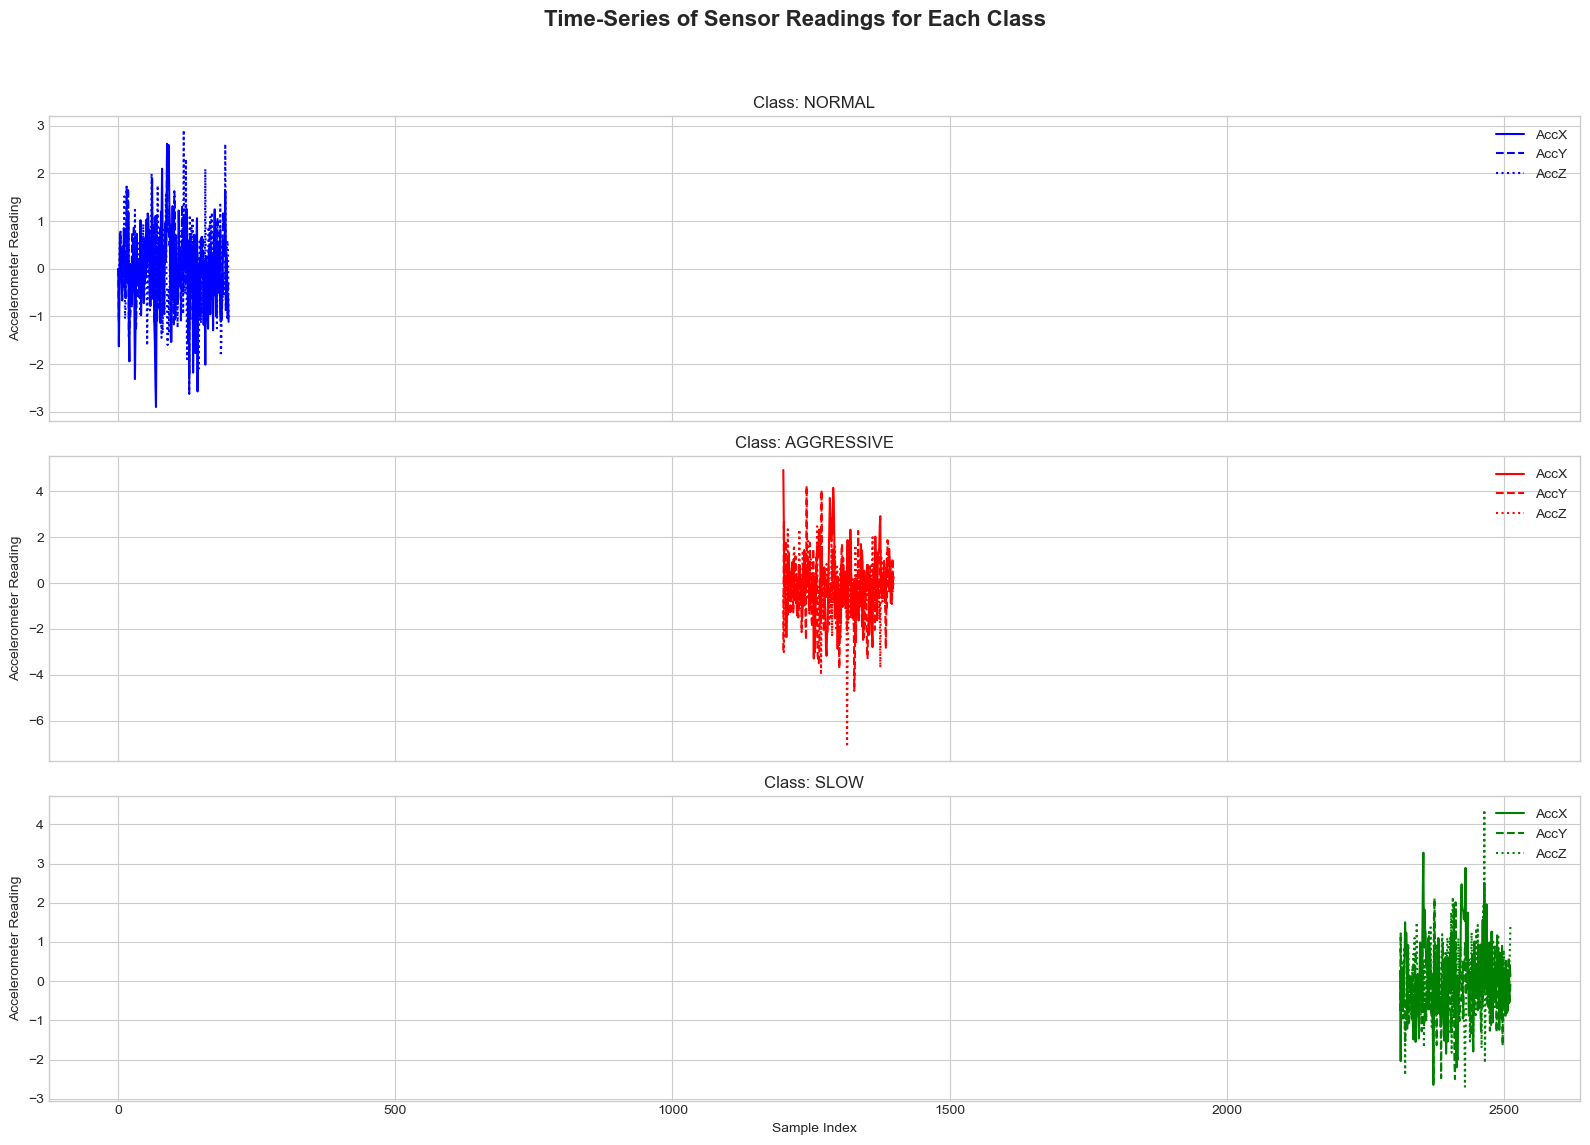

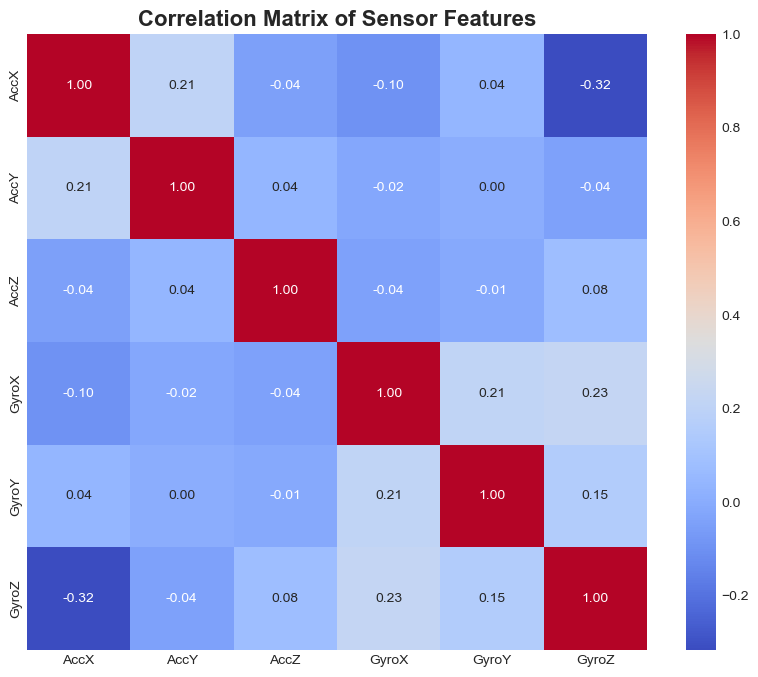

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- 1. Load the datasets ---
# Make sure the CSV files are in the same directory as your script,
# or provide the full path.

if not train_df.empty and not test_df.empty:
    # --- 2. Plot Class Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Class Distribution in Training and Testing Sets', fontsize=16, fontweight='bold')

    # Training set
    sns.countplot(ax=axes[0], x='Class', data=train_df, palette='viridis', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
    axes[0].set_title('Training Set')
    axes[0].set_xlabel('Motion Class')
    axes[0].set_ylabel('Number of Samples')

    # Testing set
    sns.countplot(ax=axes[1], x='Class', data=test_df, palette='viridis', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
    axes[1].set_title('Testing Set')
    axes[1].set_xlabel('Motion Class')
    axes[1].set_ylabel('') # Hide y-label for the second plot

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- 3. Plot Sensor Data Distribution (Box Plots) ---
    features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Sensor Data Distribution by Motion Class (Training Set)', fontsize=16, fontweight='bold')

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(ax=axes[i], x='Class', y=feature, data=train_df, palette='pastel', order=['NORMAL', 'AGGRESSIVE', 'SLOW'])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel('Motion Class')
        axes[i].set_ylabel('Sensor Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- 4. Time-Series Visualization ---
    # Let's plot a small segment of data for each class to see the patterns
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    fig.suptitle('Time-Series of Sensor Readings for Each Class', fontsize=16, fontweight='bold')
    
    class_colors = {'NORMAL': 'blue', 'AGGRESSIVE': 'red', 'SLOW': 'green'}

    for i, class_name in enumerate(['NORMAL', 'AGGRESSIVE', 'SLOW']):
        # Find the first occurrence of the class and plot the next 200 samples
        start_index = train_df[train_df['Class'] == class_name].index[0]
        segment = train_df.iloc[start_index:start_index + 200]
        
        ax = axes[i]
        segment.plot(y=['AccX', 'AccY', 'AccZ'], ax=ax, style=['-', '--', ':'], color=class_colors[class_name])
        ax.set_title(f'Class: {class_name}')
        ax.set_ylabel('Accelerometer Reading')
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel('Sample Index')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- 5. Correlation Matrix Heatmap ---
    # We only need to do this for one of the datasets, as the relationship
    # between features should be consistent.
    plt.figure(figsize=(10, 8))
    correlation_matrix = train_df[features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Sensor Features', fontsize=16, fontweight='bold')
    plt.show()



Training the best Random Forest model with the specified parameters...
Model training complete.


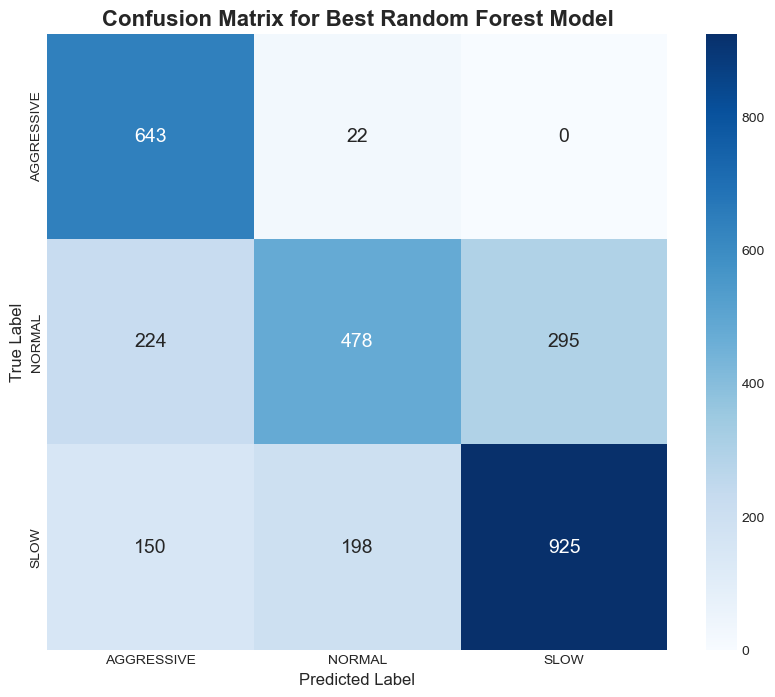

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the best parameters for your Random Forest model
# These are the parameters you found from your grid search.
best_params = {
    'n_estimators': 723,
    'max_depth': 8,
    'min_samples_leaf': 736,
    'min_samples_split': 2,  # Using int 2, as it's equivalent to 2.0 for this parameter
    'criterion': 'gini',
    'max_features': 'sqrt',
    'random_state': 42  # Add for reproducibility
}

# 2. Create and train the best model on the engineered training data
print("Training the best Random Forest model with the specified parameters...")
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_eng, y_train)
print("Model training complete.")

# 3. Make predictions on the engineered test data
y_pred = best_rf_model.predict(X_test_eng)

# 4. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class names from the LabelEncoder you already fitted
# The 'le' object should be available from the previous cells.
class_names = le.classes_

# 5. Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14}) # Increase font size for annotations

plt.title('Confusion Matrix for Best Random Forest Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


Training the best Random Forest model with the specified parameters...
Model training complete.

Test Accuracy of the Best Model: 0.6971


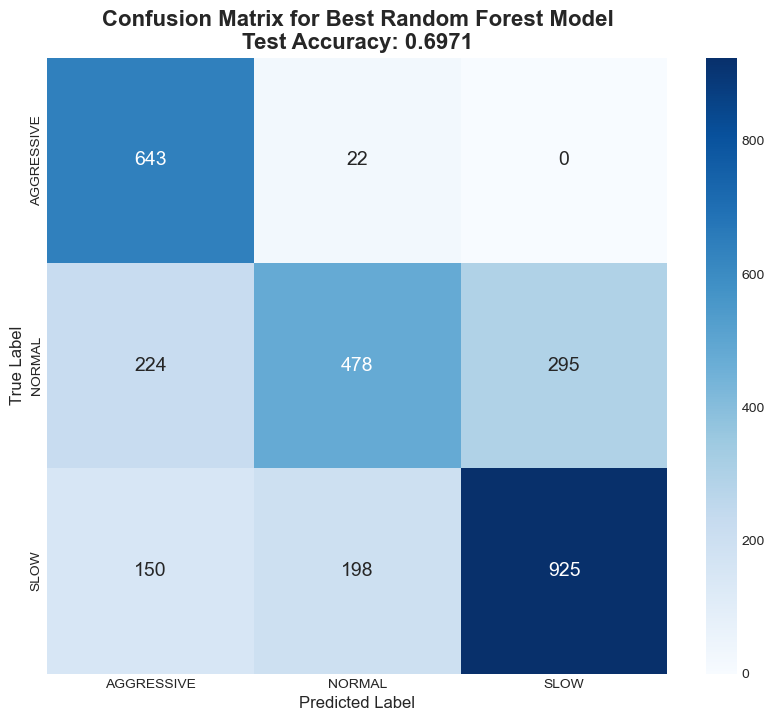

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the best parameters for your Random Forest model
# These are the parameters you provided.
best_params = {
    'n_estimators': 723,
    'max_depth': 8,
    'min_samples_leaf': 736,
    'min_samples_split': 2,  # Using int 2, as it's equivalent to 2.0 for this parameter
    'criterion': 'gini',
    'max_features': 'sqrt',
    'random_state': 42  # Add for reproducibility
}

# 2. Create and train the best model on the engineered training data
print("Training the best Random Forest model with the specified parameters...")
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_eng, y_train)
print("Model training complete.")

# 3. Make predictions on the engineered test data
y_pred = best_rf_model.predict(X_test_eng)

# 4. Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy of the Best Model: {test_accuracy:.4f}")

# 5. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the class names from the LabelEncoder you already fitted
# The 'le' object should be available from the previous cells.
class_names = le.classes_

# 6. Plot the confusion matrix as a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})

# Add the accuracy score to the title
title = f'Confusion Matrix for Best Random Forest Model\nTest Accuracy: {test_accuracy:.4f}'
plt.title(title, fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


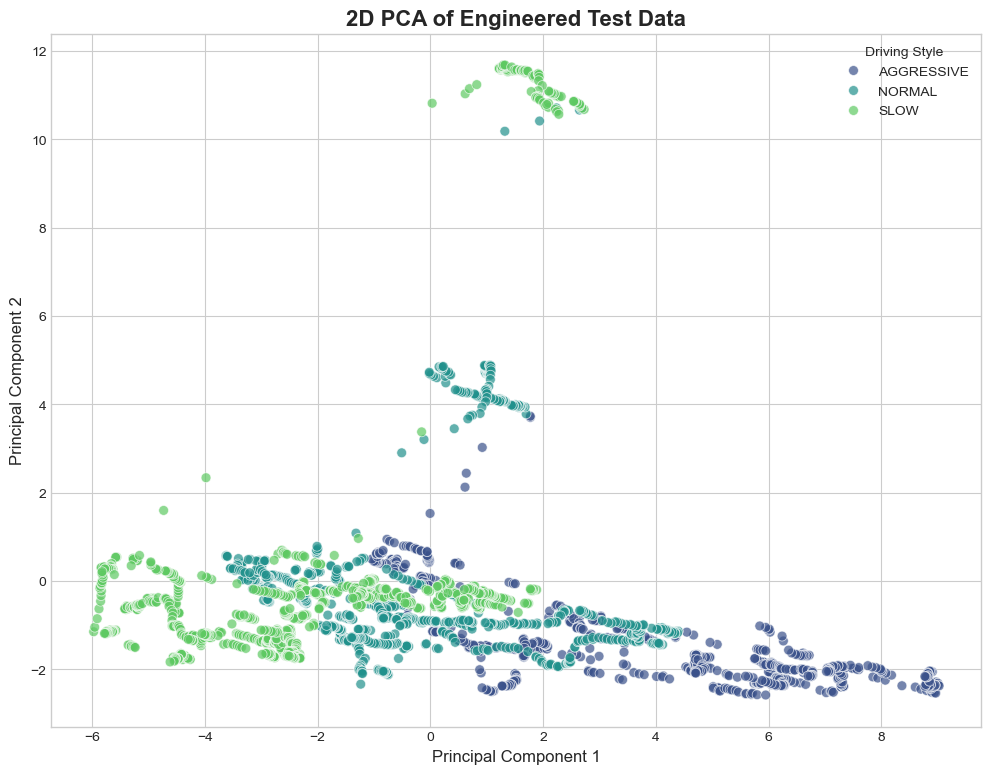

In [33]:
from sklearn.decomposition import PCA

# 1. Initialize PCA to reduce data to 2 components
pca = PCA(n_components=2)

# 2. Fit and transform the engineered test data
X_test_pca = pca.fit_transform(X_test_eng)

# 3. Create a DataFrame for plotting
pca_df = pd.DataFrame(
    data=X_test_pca, 
    columns=['Principal Component 1', 'Principal Component 2']
)
pca_df['Class'] = le.inverse_transform(y_test) # Get original string labels

# 4. Plot the 2D PCA
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2',
    hue='Class',
    palette='viridis',
    data=pca_df,
    alpha=0.7,
    s=50 # marker size
)

plt.title('2D PCA of Engineered Test Data', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Driving Style')
plt.grid(True)
plt.show()


In [21]:
results

{'GradientBoostingClassifier': {'0': {'precision': 0.46003016591251883,
   'recall': 0.3746928746928747,
   'f1-score': 0.4129993229519296,
   'support': 814.0},
  '1': {'precision': 0.3466135458167331,
   'recall': 0.08726178535606821,
   'f1-score': 0.13942307692307693,
   'support': 997.0},
  '2': {'precision': 0.4806451612903226,
   'recall': 0.819324430479183,
   'f1-score': 0.6058669764740052,
   'support': 1273.0},
  'accuracy': 0.4653047989623865,
  'macro avg': {'precision': 0.42909629100652485,
   'recall': 0.427093030176042,
   'f1-score': 0.38609645878300397,
   'support': 3084.0},
  'weighted avg': {'precision': 0.4318740436299138,
   'recall': 0.4653047989623865,
   'f1-score': 0.4041682612278168,
   'support': 3084.0},
  'test_accuracy': 0.4711413748378729},
 'BaggingClassifier': {'0': {'precision': 0.4100985221674877,
   'recall': 0.4090909090909091,
   'f1-score': 0.4095940959409594,
   'support': 814.0},
  '1': {'precision': 0.3400713436385256,
   'recall': 0.28686058

/var/folders/ph/6vsfmghs4k39mw1jfzkkk0zm0000gn/T/ipykernel_43256/2239326557.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='f1-score', y='model', data=accuracy_df, palette='viridis')


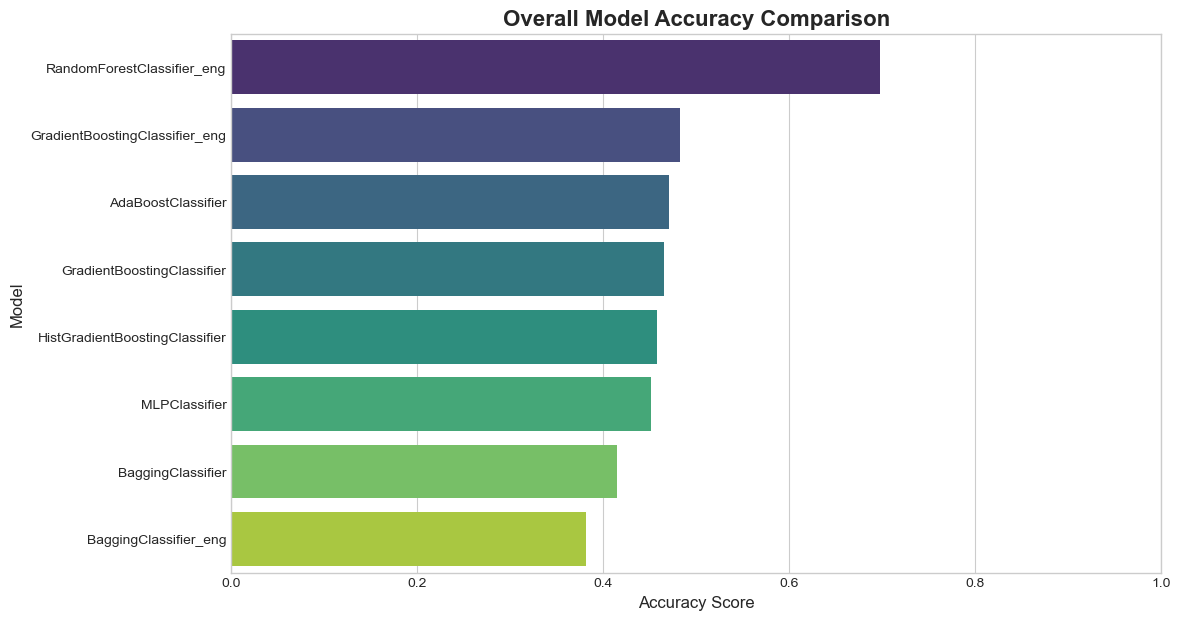

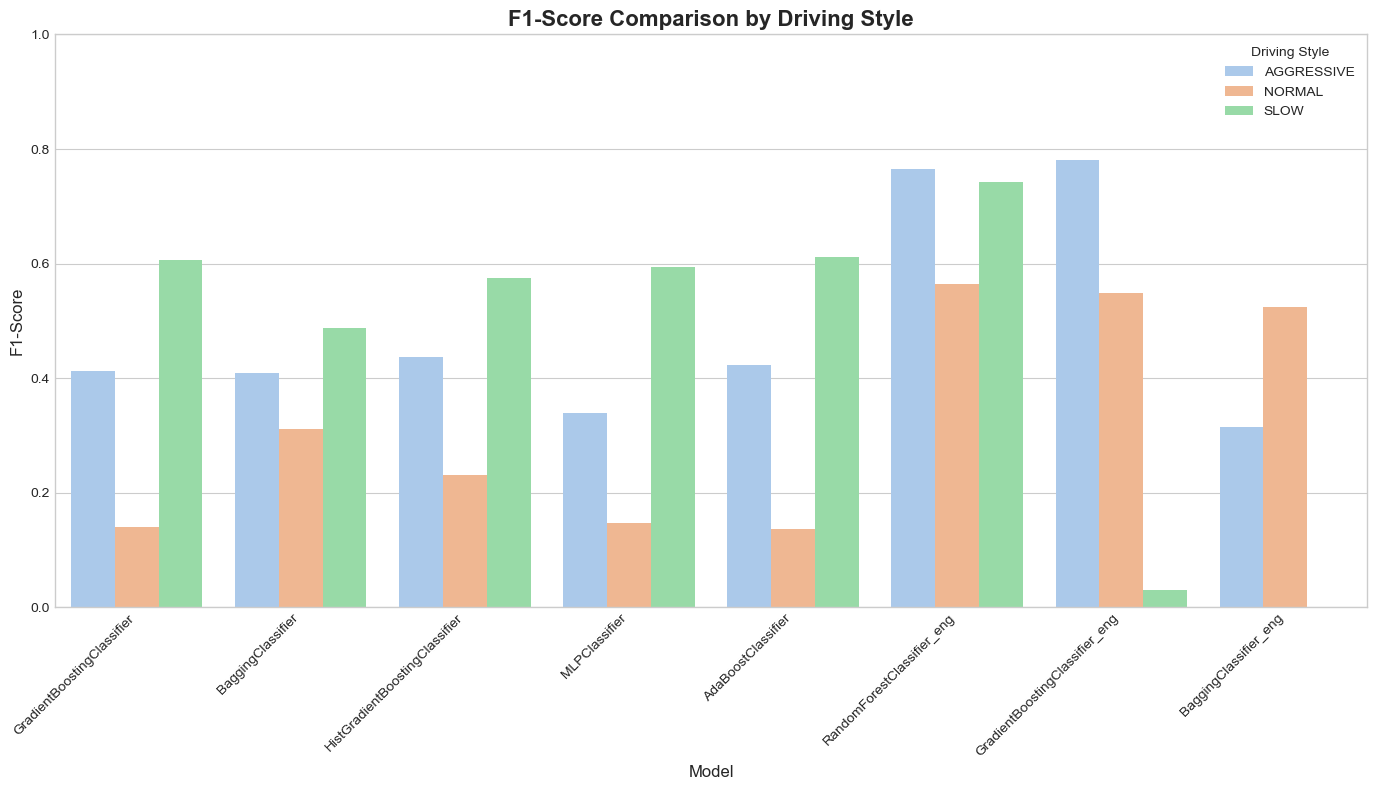

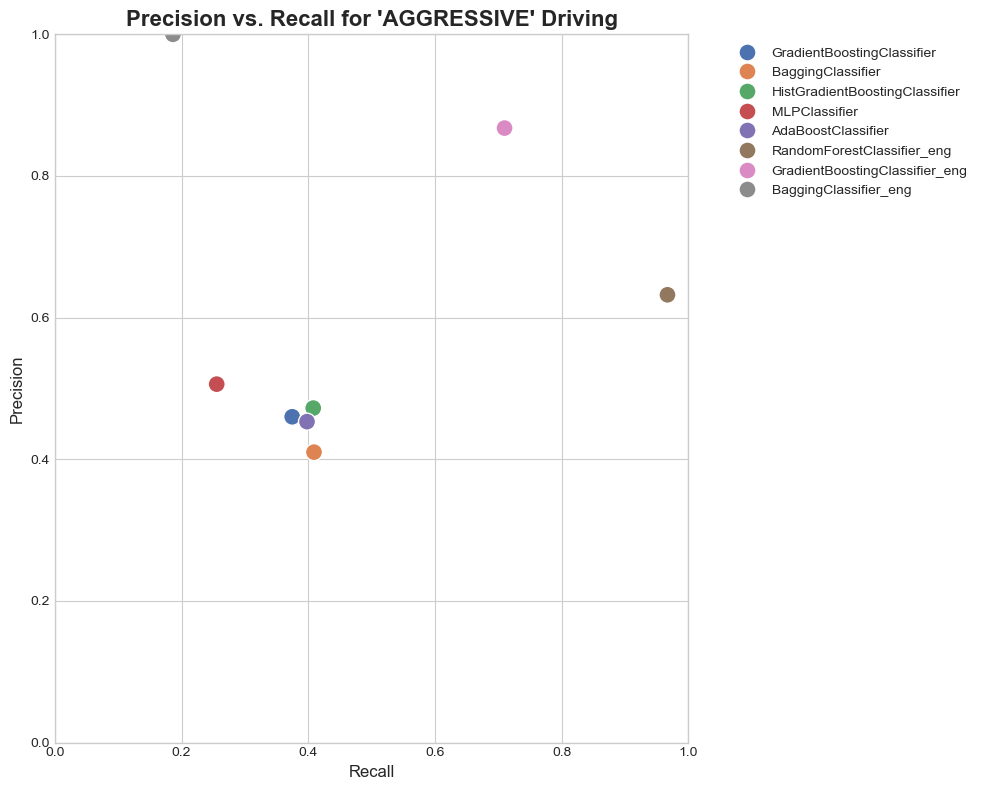

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# The LabelEncoder `le` should be available from your notebook.
# If not, you can recreate it:
# le = LabelEncoder()
# le.fit(['AGGRESSIVE', 'NORMAL', 'SLOW'])
class_names = le.classes_ # Should be ['AGGRESSIVE', 'NORMAL', 'SLOW']

# --- 2. Prepare data for plotting ---
plot_data = []
for model_name, report in results.items():
    # Overall accuracy
    plot_data.append({
        'model': model_name,
        'class': 'Overall',
        'f1-score': report['accuracy'],
        'metric': 'Accuracy'
    })
    # F1-score for each class
    for class_idx, class_name in enumerate(class_names):
        plot_data.append({
            'model': model_name,
            'class': class_name,
            'f1-score': report[str(class_idx)]['f1-score'],
            'metric': 'F1-Score'
        })

plot_df = pd.DataFrame(plot_data)

# --- 3. Plot 1: Overall Accuracy Comparison ---
plt.figure(figsize=(12, 7))
accuracy_df = plot_df[plot_df['metric'] == 'Accuracy'].sort_values('f1-score', ascending=False)
sns.barplot(x='f1-score', y='model', data=accuracy_df, palette='viridis')
plt.title('Overall Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.show()

# --- 4. Plot 2: F1-Score by Class ---
plt.figure(figsize=(14, 8))
f1_df = plot_df[plot_df['metric'] == 'F1-Score']
sns.barplot(x='model', y='f1-score', hue='class', data=f1_df, palette='pastel')
plt.title('F1-Score Comparison by Driving Style', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(title='Driving Style')
plt.tight_layout()
plt.show()

# --- 5. Plot 3: Precision vs. Recall for 'AGGRESSIVE' Class ---
pr_data = []
for model_name, report in results.items():
    # Class '0' corresponds to 'AGGRESSIVE'
    pr_data.append({
        'model': model_name,
        'precision': report['0']['precision'],
        'recall': report['0']['recall']
    })
pr_df = pd.DataFrame(pr_data)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='recall', y='precision', data=pr_df, hue='model', s=150, palette='deep')
plt.title("Precision vs. Recall for 'AGGRESSIVE' Driving", fontsize=16, fontweight='bold')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Training Random Forest model with balanced class weights...
Model training complete.

Test Accuracy with Class Weights: 0.4807

           CLASSIFICATION REPORT (WITH CLASS WEIGHTS)
              precision    recall  f1-score   support

  AGGRESSIVE       0.63      0.96      0.76       665
      NORMAL       0.40      0.78      0.53       997
        SLOW       0.00      0.00      0.00      1273

    accuracy                           0.48      2935
   macro avg       0.34      0.58      0.43      2935
weighted avg       0.28      0.48      0.35      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

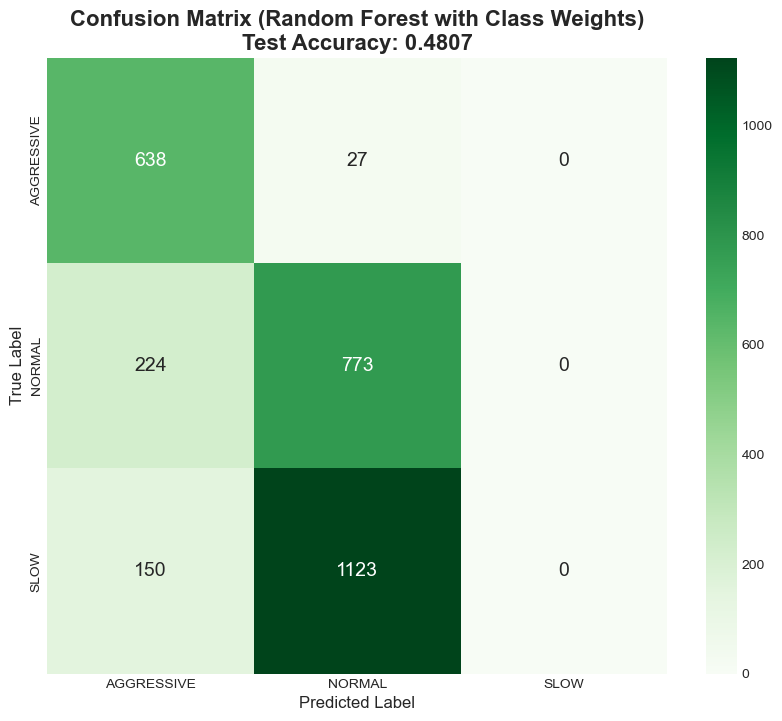

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define the best parameters, but this time add class_weight
# We'll use the same parameters you found from your grid search
best_params_weighted = {
    'n_estimators': 723,
    'max_depth': 8,
    'min_samples_leaf': 736,
    'min_samples_split': 2,
    'criterion': 'gini',
    'max_features': 'sqrt',
    'random_state': 42,
    'class_weight': 'balanced'  # The key addition!
}

# 2. Create and train the model
print("Training Random Forest model with balanced class weights...")
rf_weighted_model = RandomForestClassifier(**best_params_weighted)
rf_weighted_model.fit(X_train_eng, y_train)
print("Model training complete.")

# 3. Make predictions and evaluate
y_pred_weighted = rf_weighted_model.predict(X_test_eng)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)

# 4. Print the report and display the confusion matrix
print(f"\nTest Accuracy with Class Weights: {accuracy_weighted:.4f}\n")
print("="*60)
print("           CLASSIFICATION REPORT (WITH CLASS WEIGHTS)")
print("="*60)
print(classification_report(y_test, y_pred_weighted, target_names=le.classes_))

# Plot the confusion matrix
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 14})

title = f'Confusion Matrix (Random Forest with Class Weights)\nTest Accuracy: {accuracy_weighted:.4f}'
plt.title(title, fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


In [24]:
import xgboost as xgb

# 1. Define the XGBoost model
# Note: XGBoost requires labels to be 0, 1, 2... which your LabelEncoder already provides.
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)

# 2. Define the parameter grid for XGBoost
# This is a focused grid to keep search times reasonable.
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1]
}

# 3. Run the grid search
print("\nRUNNING GRID SEARCH ON XGBOOST CLASSIFIER MODEL")
name, report = run_grid_search(xgb_model, param_grid_xgb, X_train_eng, y_train, X_test_eng, y_test)

# Store the results
results[name + '_eng'] = report



RUNNING GRID SEARCH ON XGBOOST CLASSIFIER MODEL
Testing 16 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished



Grid Search completed in 0.50 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.3397
----------------------------------------
n_estimators: 200.0
learning_rate: 0.05
max_depth: 4.0
subsample: 0.8
colsample_bytree: 0.8
gamma: 0.0
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       665
           1       0.34      1.00      0.51       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.34      2935
   macro avg       0.11      0.33      0.17      2935
weighted avg       0.12      0.34      0.17      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [25]:
import xgboost as xgb

# 1. Define the XGBoost model
# Note: XGBoost requires labels to be 0, 1, 2... which your LabelEncoder already provides.
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)

# 2. Define the parameter grid for XGBoost
# This is a focused grid to keep search times reasonable.
param_grid_xgb = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1]
}

# 3. Run the grid search
print("\nRUNNING GRID SEARCH ON XGBOOST CLASSIFIER MODEL")
name, report = run_grid_search(xgb_model, param_grid_xgb, X_train_eng, y_train, X_test_eng, y_test)

# Store the results
results[name + '_eng'] = report



RUNNING GRID SEARCH ON XGBOOST CLASSIFIER MODEL
Testing 16 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.4s finished



Grid Search completed in 0.43 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.3397
----------------------------------------
n_estimators: 200.0
learning_rate: 0.05
max_depth: 4.0
subsample: 0.8
colsample_bytree: 0.8
gamma: 0.0
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       665
           1       0.34      1.00      0.51       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.34      2935
   macro avg       0.11      0.33      0.17      2935
weighted avg       0.12      0.34      0.17      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [26]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Apply SMOTE to the training data
# This creates a new, balanced training set.
print("Original training data distribution:")
print(pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_eng, y_train)

print("\nNew, balanced training data distribution:")
print(pd.Series(y_train_smote).value_counts())

# 2. Define the XGBoost model and a refined parameter grid
# We'll use a more focused grid this time.
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# A more targeted parameter grid for XGBoost
param_grid_xgb_smote = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0, 0.1] # A regularization parameter
}

# 3. Run the grid search using the SMOTE-balanced data
print("\nRUNNING GRID SEARCH ON XGBOOST WITH SMOTE DATA")
name, report = run_grid_search(xgb_model, param_grid_xgb_smote, X_train_smote, y_train_smote, X_test_eng, y_test)

# Store and display results
results[name + '_eng_smote'] = report


Original training data distribution:
2    1331
0    1113
1    1051
Name: count, dtype: int64

New, balanced training data distribution:
1    1331
0    1331
2    1331
Name: count, dtype: int64

RUNNING GRID SEARCH ON XGBOOST WITH SMOTE DATA
Testing 16 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:03:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1763746887906/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:03:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1763746887906/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:03:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1763746887906/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jakeshavel/anaconda


Grid Search completed in 0.51 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4954
----------------------------------------
n_estimators: 400.0
learning_rate: 0.05
max_depth: 4.0
subsample: 0.8
colsample_bytree: 0.8
gamma: 0.0
----------------------------------------


/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [18:03:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1763746887906/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.99      0.69      0.82       665
           1       0.40      1.00      0.57       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.50      2935
   macro avg       0.47      0.56      0.46      2935
weighted avg       0.36      0.50      0.38      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [27]:
from sklearn.ensemble import RandomForestClassifier

# 1. Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Define a new, more focused parameter grid
# We're exploring different levels of regularization.
param_grid_rf_refined = {
    'n_estimators': [500, 700],
    'max_depth': [8, 10],
    'min_samples_leaf': [10, 50, 100], # Key regularization parameter
    'min_samples_split': [2, 10],
    'max_features': ['sqrt', 0.5] # Try a fraction of features too
}

# 3. Run the grid search
print("\nRUNNING REFINED GRID SEARCH ON RANDOM FOREST MODEL")
name, report = run_grid_search(rf_model, param_grid_rf_refined, X_train_eng, y_train, X_test_eng, y_test)

# Store the results
results[name + '_eng_refined'] = report



RUNNING REFINED GRID SEARCH ON RANDOM FOREST MODEL
Testing 48 candidate models...
--------------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   12.6s finished



Grid Search completed in 12.57 seconds.

       WINNING MODEL FOUND
Best Test Accuracy: 0.4753
----------------------------------------
n_estimators: 500
max_depth: 10
min_samples_leaf: 50
min_samples_split: 10
max_features: 0.5
----------------------------------------

                     CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       665
           1       0.39      0.94      0.55       997
           2       0.00      0.00      0.00      1273

    accuracy                           0.48      2935
   macro avg       0.43      0.54      0.44      2935
weighted avg       0.33      0.48      0.36      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

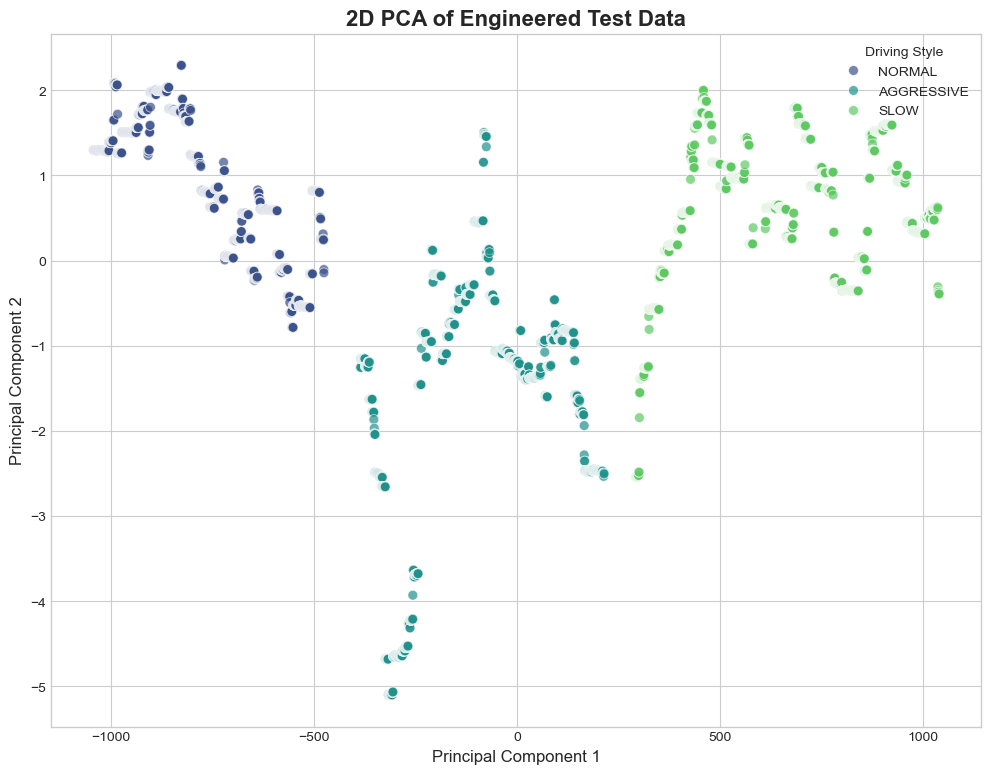

In [34]:
from sklearn.decomposition import PCA

# 1. Initialize PCA to reduce data to 2 components
pca = PCA(n_components=2)

# 2. Fit and transform the engineered test data
X_test_pca = pca.fit_transform(X_train)

# 3. Create a DataFrame for plotting
pca_df = pd.DataFrame(
    data=X_test_pca, 
    columns=['Principal Component 1', 'Principal Component 2']
)
pca_df['Class'] = le.inverse_transform(y_train) # Get original string labels

# 4. Plot the 2D PCA
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2',
    hue='Class',
    palette='viridis',
    data=pca_df,
    alpha=0.7,
    s=50 # marker size
)

plt.title('2D PCA of Engineered Test Data', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Driving Style')
plt.grid(True)
plt.show()


Fitting PCA on the original training data...
PCA fitting complete.
Training Logistic Regression model on 2D PCA features...
Model training complete.

Test Accuracy using PCA + Logistic Regression: 0.3397

     CLASSIFICATION REPORT (PCA + LOGISTIC REGRESSION)
              precision    recall  f1-score   support

  AGGRESSIVE       0.00      0.00      0.00       665
      NORMAL       0.34      1.00      0.51       997
        SLOW       0.00      0.00      0.00      1273

    accuracy                           0.34      2935
   macro avg       0.11      0.33      0.17      2935
weighted avg       0.12      0.34      0.17      2935



/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakeshavel/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

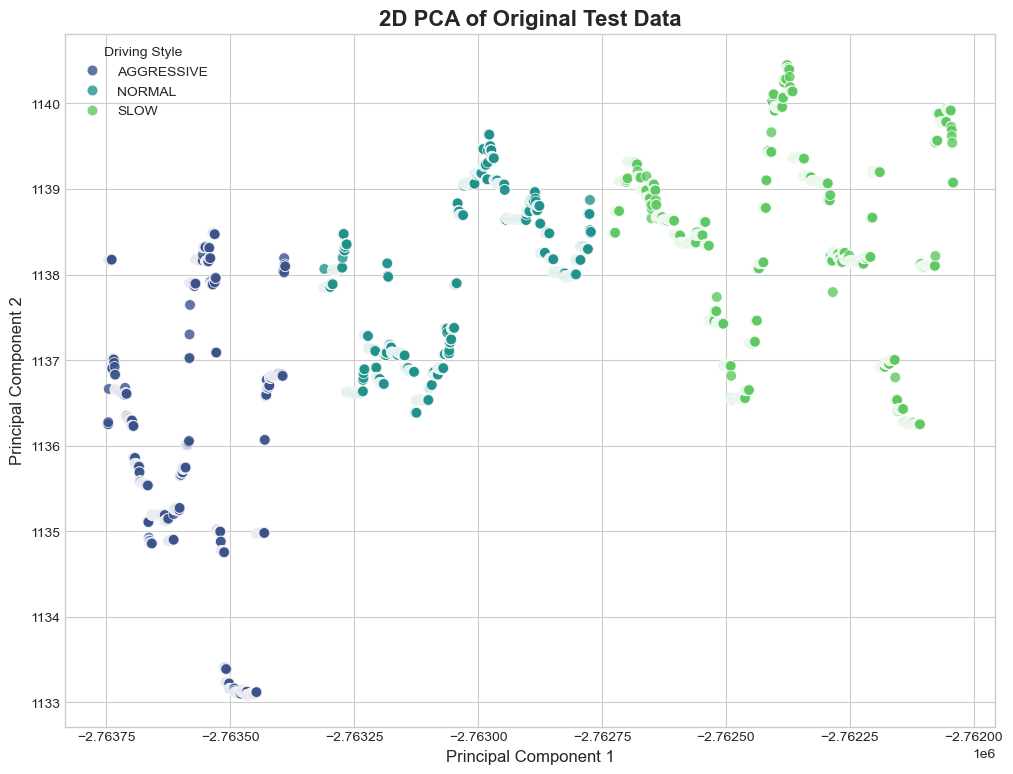

In [35]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Note: This cell should be run using the original, non-engineered data.
# Ensure X_train, y_train, X_test, and y_test are from the cell where you first
# split and scaled the raw CSV data.

# 1. Train PCA on the original training data to find the best 2D projection
print("Fitting PCA on the original training data...")
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
print("PCA fitting complete.")

# 2. Use the SAME trained PCA to transform the test data
# This is crucial for ensuring the test data is projected into the same space.
X_test_pca = pca.transform(X_test)

# 3. Train a simple classifier on the new 2D training data
print("Training Logistic Regression model on 2D PCA features...")
# We use a simple Logistic Regression model because the data looks separable
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_pca, y_train)
print("Model training complete.")

# 4. Predict on the transformed 2D test data and evaluate
y_pred_pca = log_reg_model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nTest Accuracy using PCA + Logistic Regression: {accuracy_pca:.4f}\n")
print("="*60)
print("     CLASSIFICATION REPORT (PCA + LOGISTIC REGRESSION)")
print("="*60)
print(classification_report(y_test, y_pred_pca, target_names=le.classes_))

# 5. Visualize the PCA-transformed TEST data to see if the separation holds
pca_test_df = pd.DataFrame(
    data=X_test_pca, 
    columns=['Principal Component 1', 'Principal Component 2']
)
# Use le.inverse_transform to get the original string labels for plotting
pca_test_df['Class'] = le.inverse_transform(y_test)

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Principal Component 1', 
    y='Principal Component 2',
    hue='Class',
    palette='viridis',
    data=pca_test_df,
    alpha=0.8,
    s=60
)

plt.title('2D PCA of Original Test Data', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Driving Style')
plt.grid(True)
plt.show()


In [37]:
# --- Start of Corrected Code ---

# Shuffle the training dataframe to prevent any ordering bias
train_df_shuffled = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features (X) and target (y)
features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
target = 'Class'

# Get train and test subsets from the SHUFFLED data
X_train = train_df_shuffled[features]
y_train_labels = train_df_shuffled[target]
X_test = test_df[features]  # Test set doesn't need shuffling
y_test_labels = test_df[target]

# Encode labels into numbers that can be processed by various ML models.
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.transform(y_test_labels)

# Scale X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- End of Corrected Code ---
